<a href="https://colab.research.google.com/github/Htetmin5235/Myreport/blob/master/HOMEWORK1%2C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pylab as plt
import tensorflow as tf

In [3]:
!pip install -U tf-hub-nightly
!pip install tfds-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 102kB 2.2MB/s 
     |████████████████████████████████| 3.3MB 2.7MB/s 


## An ImageNet classifier

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

65536/61306 [================================] - 0s 0us/step


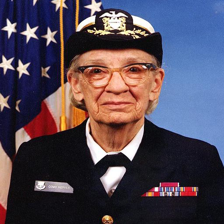

In [0]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [0]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [0]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [0]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


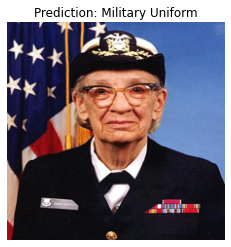

In [0]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

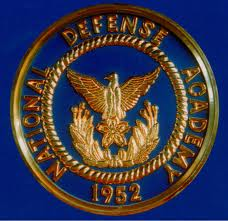

In [30]:
from IPython.display import  Image
Image(filename='/content/drive/My Drive/htet/STICKER/NDA.jpg')

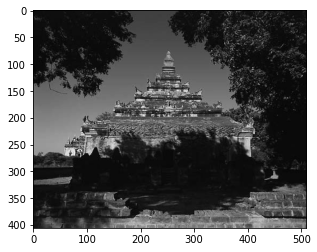

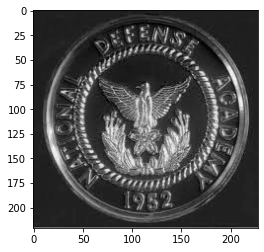

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

DATADIR ="/content/drive/My Drive/htet"
CATEGORIES=["PAGODA","STICKER"]
for category in CATEGORIES:
  path = os.path.join(DATADIR,category)
  for img in os.listdir(path):
    img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array,cmap="gray")
    plt.show()
    break
    break

In [33]:
print(img_array)

[[ 29  29  29 ...  31  31  31]
 [ 29  29  29 ...  31  31  31]
 [ 29  29  29 ...  31  31  31]
 ...
 [ 29  29  29 ...  29  29  29]
 [ 25  25  25 ...  28  28  28]
 [101 101 101 ... 105 105 105]]


In [34]:
print(img_array.shape)

(221, 228)


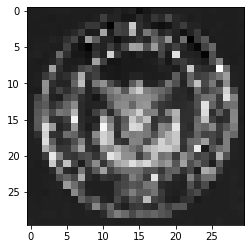

In [35]:
IMG_SIZE=30
new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array,cmap='gray')
plt.show()

### Dataset

In [0]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 3s 0us/step


In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [0]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### Run the classifier on a batch of images

In [0]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [0]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['buckeye', 'picket fence', 'daisy', 'picket fence', 'sea urchin',
       'picket fence', 'daisy', 'daisy', 'daisy', 'wool', 'picket fence',
       'daisy', 'pot', 'daisy', 'buckeye', 'daisy', 'tarantula',
       'stone wall', 'coral fungus', 'chainlink fence', 'pot', 'daisy',
       'jigsaw puzzle', 'coral fungus', 'daisy', 'daisy', 'daisy',
       'picket fence', 'handkerchief', 'pinwheel', 'bell pepper', 'vase'],
      dtype='<U30')

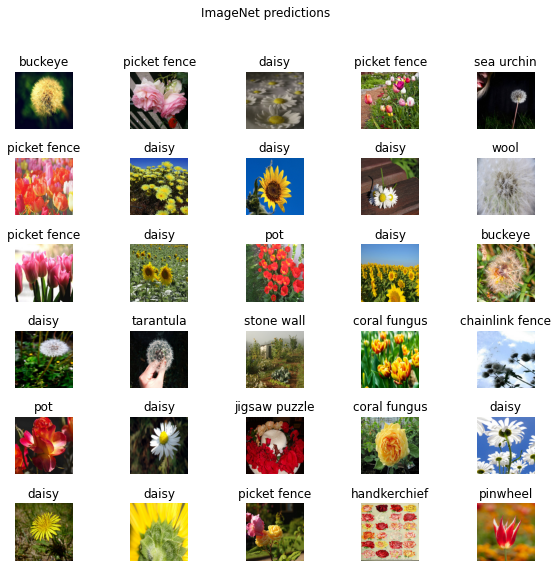

In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [0]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

### Attach a classification head

In [0]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [0]:
predictions.shape

TensorShape([32, 5])

### Train the model

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [0]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
115/115 [==============================] - 126s 1s/step - loss: 0.3958 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 122s 1s/step - loss: 0.3679 - acc: 0.8438


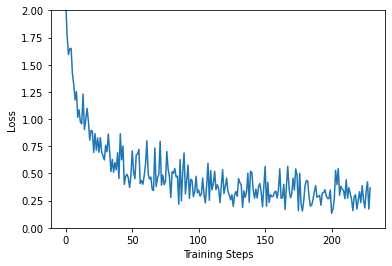

In [0]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

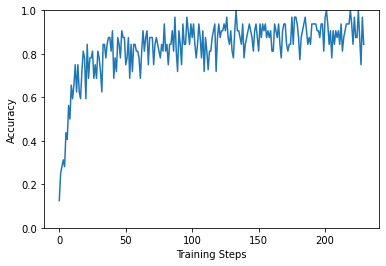

In [0]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

In [0]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch, axis=-1)

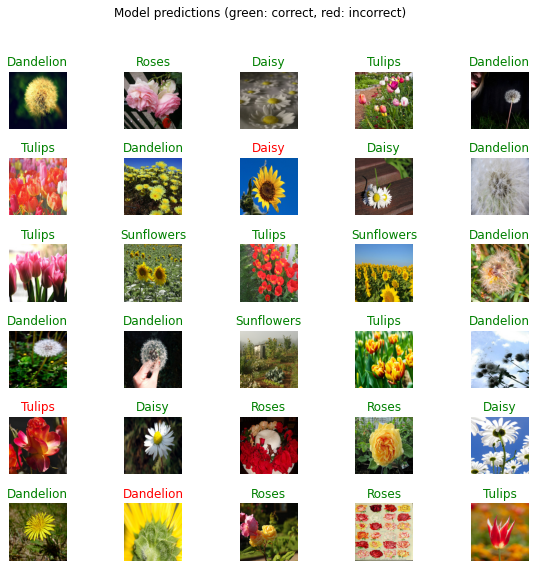

In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export your model

In [0]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1591487803/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1591487803/assets


'/tmp/saved_models/1591487803'

In [0]:
reloaded = tf.keras.models.load_model(export_path)

In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [0]:
abs(reloaded_result_batch - result_batch).max()

0.0